In [1]:
from fastai.tabular import *
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
import pprint
from sklearn.utils import shuffle
p = pprint.PrettyPrinter(indent=4, width=30)
pretty = p.pprint

print('libraries loaded')

libraries loaded


In [2]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # Note: there's a leading space for each column name except for the first one
        # let's strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        df.drop(columns=['Source IP', 'Destination IP'], inplace=True)
        # drop missing values/NaN etc.
        df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]=='NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        # convert  Flow Bytes/s object & Flow Packets/s object into float type
        df['Flow Bytes/s'] = df['Flow Bytes/s'].astype('float64')
        df['Flow Packets/s'] = df['Flow Packets/s'].astype('float64')
        print(df.tail())
        df.to_pickle(pickleDump)
    
    return df

In [8]:

print('relevant libraries uploaded')

# Choose your own filepath for arff file
filepath = 'CICDataSet-TOR/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR.arff'
raw_data = loadarff(filepath)

# Converting arff file into pandas dataframe
df_data = pd.DataFrame(raw_data[0])

# Now, you can perform pandas methods if it is easy enough for you
print(df_data['class1'].value_counts())
column_name = list(df_data.columns)
print(column_name)
    
dataPath = 'CICDataSet-TOR/Scenario-A'
csvFile = os.path.join(dataPath, 'merged_5s.csv')


relevant libraries uploaded
b'NONTOR'    18758
b'TOR'        3314
Name: class1, dtype: int64
['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'class1']


In [9]:
df = loadData(csvFile)

In [10]:
# check datatypes of each features
df.dtypes

Source Port           int64
Destination Port      int64
Protocol              int64
Flow Duration         int64
Flow Bytes/s        float64
Flow Packets/s      float64
Flow IAT Mean       float64
Flow IAT Std        float64
Flow IAT Max          int64
Flow IAT Min          int64
Fwd IAT Mean        float64
Fwd IAT Std         float64
Fwd IAT Max           int64
Fwd IAT Min           int64
Bwd IAT Mean        float64
Bwd IAT Std         float64
Bwd IAT Max           int64
Bwd IAT Min           int64
Active Mean           int64
Active Std            int64
Active Max            int64
Active Min            int64
Idle Mean             int64
Idle Std              int64
Idle Max              int64
Idle Min              int64
label                object
dtype: object

In [11]:
df_data.dtypes

duration              float64
total_fiat            float64
total_biat            float64
min_fiat              float64
min_biat              float64
max_fiat              float64
max_biat              float64
mean_fiat             float64
mean_biat             float64
flowPktsPerSecond     float64
flowBytesPerSecond    float64
min_flowiat           float64
max_flowiat           float64
mean_flowiat          float64
std_flowiat           float64
min_active            float64
mean_active           float64
max_active            float64
std_active            float64
min_idle              float64
mean_idle             float64
max_idle              float64
std_idle              float64
class1                 object
dtype: object

In [12]:
# total Tor samples
print('total TOR:', len(df[df['label'] == 'TOR'].index))
print('total nonTOR: ', len(df[df['label'] == 'nonTOR'].index))

total TOR: 14508
total nonTOR:  69684


In [13]:
dep_var = 'label'
cat_names = ['Source Port', 'Destination Port', 'Protocol']
cont_names = list(set(df.columns) - set(cat_names) - set([dep_var]))

In [14]:
cont_names

['Idle Max',
 'Bwd IAT Max',
 'Active Max',
 'Fwd IAT Std',
 'Fwd IAT Mean',
 'Flow Packets/s',
 'Bwd IAT Std',
 'Flow Bytes/s',
 'Active Std',
 'Fwd IAT Max',
 'Bwd IAT Mean',
 'Flow IAT Min',
 'Idle Mean',
 'Flow IAT Std',
 'Idle Std',
 'Flow Duration',
 'Active Mean',
 'Idle Min',
 'Flow IAT Mean',
 'Active Min',
 'Fwd IAT Min',
 'Bwd IAT Min',
 'Flow IAT Max']

In [15]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.172338,01:00
1,nan,nan,0.172338,01:01
2,nan,nan,0.172338,00:59
3,nan,nan,0.172338,00:54
4,nan,nan,0.172338,01:01
5,nan,nan,0.172338,01:01
6,nan,nan,0.172338,00:58
7,nan,nan,0.172338,01:00
8,nan,nan,0.172338,00:58
9,nan,nan,0.172338,00:57


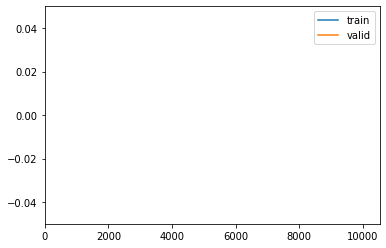

In [17]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
    model.save('{}.model'.format(os.path.basename(csvFile)))

In [ ]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

In [ ]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()

In [24]:
# total Tor samples
print('total TOR:', len(df_data[df_data['label'] == 'TOR'].index))
print('total nonTOR: ', len(df_data[df_data['label'] == 'nonTOR'].index))

KeyError: 'label'

In [22]:
dep_var = 'label'
cat_names = ['Source Port', 'Destination Port', 'Protocol']
cont_names = list(set(df_data.columns) - set(cat_names) - set([dep_var]))

In [21]:
cont_names

['mean_active',
 'duration',
 'total_biat',
 'min_flowiat',
 'max_active',
 'std_flowiat',
 'mean_fiat',
 'min_active',
 'max_flowiat',
 'max_idle',
 'min_idle',
 'total_fiat',
 'std_active',
 'mean_biat',
 'std_idle',
 'max_fiat',
 'mean_idle',
 'min_fiat',
 'max_biat',
 'min_biat',
 'flowBytesPerSecond',
 'class1',
 'flowPktsPerSecond',
 'mean_flowiat']

In [25]:
for train_idx, test_idx in sss.split(df_data.index, df_data[dep_var]):
    data_fold = (TabularList.from_df(df_data, path=filepath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
    model.save('{}.model'.format(os.path.basename(filepath)))

KeyError: 'label'